# LST with the repetition code on GHZ states

## Setup

In [1]:
import functools
import itertools

from typing import List, Dict

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif","font.size": 12})
import cirq
import qiskit
import qiskit_ibm_runtime

import sys
sys.path.append("src/")
from repetition_code import logical_H, logical_CNOT
from LST import int_to_bin_list
sys.path.append("notebooks/analog/h2_exp/")

In [2]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set experiment parameters

In [ ]:
# IBM service, computer, and qubits to use.
service = qiskit_ibm_runtime.QiskitRuntimeService(
    channel="your",
    token="info",
    instance="here",
)
computer = service.backend("")

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    1: [3, 4],
    3: [3, 4, 5, 15, 21, 22],
    5: [3, 4, 5, 6, 15, 20, 21, 22, 23, 24],
    7: [0, 1, 2, 3, 4, 5, 6, 14, 15, 18, 19, 20, 21, 22],
}

In [ ]:
nvals = [3, 5, 7]      # Numbers of physical qubits (distances of repetition code) to use.

depth: int = 0         # How many times to repeat the circuit U (U^dag U) ^ depth where U is the logical Bell state preparation circuit.
nshots: int = 20_000   # Number of samples.
k = 2                  # Number of logical qubits.

### Helper functions

In [3]:
def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements


def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key)))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

def int_to_bin_str(x, length):
    return functools.reduce(lambda a, b: a + b, [str(b) for b in int_to_bin_list(x, length)])


def logical_observable(
    paulistring: str,
    n: int
) -> cirq.PauliString:
    q = cirq.LineQubit.range(n*len(paulistring))
    string = cirq.PauliString()
    for i, p in enumerate(paulistring):
        if p == "X":
            string *= functools.reduce(lambda a, b: a * b, [cirq.X.on(q[j]) for j in range(n*i, n*(i+1))])
        elif p == "Z":
            string *= cirq.Z.on(q[n*i])
    return string

## Run the unmitigated / unencoded experiment as a baseline

In [6]:
qreg = cirq.LineQubit.range(k)
circuit = cirq.Circuit(
    cirq.H.on(qreg[0]),
    cirq.CNOT.on(*qreg),
)
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
circuit.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [7]:
# Compile to device.
compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  # Hardcode n = 1 (i.e., no encoding) to get layout.
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

# Optionally repeat the circuit U -> U (U^\dag U)^depth.
base = compiled_raw.copy()
for _ in range(depth):
    compiled_raw = compiled_raw.compose(base.inverse())
    compiled_raw = compiled_raw.compose(base)
compiled_raw.measure_active()

# Compile one more time with optimization_level=0 (some inverse gates may not be supported).
compiled_raw = qiskit.transpile(compiled_raw, backend=computer, optimization_level=0)

compiled_raw.draw(fold=-1, idle_wires=False)

global phase: 2π
           ┌──────────┐┌────┐┌─────────────┐┌────┐┌──────────┐┌──────┐  ┌─────────┐   ┌────┐┌─────────────┐ ░ ┌─┐   
  q_3 -> 3 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-2.0153) ├┤ √X ├┤ Rz(-π/2) ├┤1     ├──┤ Rz(π/2) ├───┤ √X ├┤ Rz(-2.0153) ├─░─┤M├───
           ├──────────┤├────┤├─────────────┤└────┘└──────────┘│  Ecr │┌─┴─────────┴──┐├────┤└─┬─────────┬─┘ ░ └╥┘┌─┐
  q_4 -> 4 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-2.5564) ├──────────────────┤0     ├┤ Rz(-0.98561) ├┤ √X ├──┤ Rz(π/2) ├───░──╫─┤M├
           └──────────┘└────┘└─────────────┘                  └──────┘└──────────────┘└────┘  └─────────┘   ░  ║ └╥┘
measure: 2/════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩═
                                                                                                               0  1

In [8]:
"""Run the job."""
job = computer.run(
    compiled_raw,
    shots=nshots,
    memory=True,
)
# job = service.job(job_id="cshov4tfltjvipt17ch0")

/tmp/ipykernel_38788/2532403488.py:2: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = computer.run(


In [16]:
counts = job.result().get_counts()
counts

{'00': 9584, '10': 242, '01': 403, '11': 9771}

In [17]:
raw_value = compute_expectation(cirq.Z.on(qreg[0]) * cirq.Z.on(qreg[1]), counts)
raw_value

0.9355

## Run the mitigated experiment

In [9]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [10]:
sampler = Sampler(computer)

In [11]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [12]:
sampler.options

max_execution_time,Unset
default_shots,Unset
experimental,Unset
▸environment,EnvironmentOptions
log_level,'WARNING'
callback,None
job_tags,None
private,False
▸simulator,SimulatorOptions
noise_model,Unset
seed_simulator,Unset


In [13]:
to_run = []
all_elements = []
all_observables = []
all_paulis = []

for n in nvals:
    # Build the stabilizer group and elements.
    qubits = cirq.LineQubit.range(n * k)
    generators = []
    for i in range(k):
        generators += [cirq.Z.on(qubits[i*n + j]) * cirq.Z.on(qubits[i*n + j + 1]) for j in range(n - 1)]

    elements = generate_stabilizer_elements(generators)  # TODO: Do this in blocks (see Fig. 1 of LST paper).
    all_elements.append(elements)

    # Build the observable and circuit.
    observable = logical_observable("ZZ", n)
    all_observables.append(observable)
    paulis = [observable * p for p in elements]
    all_paulis.append(paulis)

    circuit = cirq.Circuit()
    logical_H(circuit, qubits, n, qi=0)
    logical_CNOT(circuit, qubits, n, 0, 1)
    circuit = circuit[n - 1:]  # Simplify logical H at start of circuit.
    
    # Convert to Qiskit.
    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())

    # Compile to device.
    compiled = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[n],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=3,
    )

    # Optionally repeat the circuit U -> U (U^\dag U)^depth.
    base = compiled.copy()
    for _ in range(depth):
        compiled = compiled.compose(base.inverse())
        compiled = compiled.compose(base)
    compiled.measure_active()

    # Compile one more time with optimization_level=0 (some inverse gates may not be supported).
    compiled = qiskit.transpile(compiled, backend=computer, optimization_level=0)

    to_run.append(compiled)

In [14]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: 3π/2
            ┌─────────┐ ┌────┐               ┌──────┐┌─────────┐         ┌──────┐ ┌────────┐  ┌────┐   ┌─────────┐                                                                                                                                                           ┌──────┐┌──────────┐ ┌────┐  ┌────────┐     ┌──────┐   ┌─────────┐      ┌────┐     ┌─────────┐  ┌──────┐  ┌──────────┐   ┌────┐                      ┌──────┐┌──────────┐   ┌────┐    ┌────────┐           ┌──────┐┌─────────┐  ┌────┐ ┌─────────┐          ┌──────┐    ┌────┐   ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ ┌─┐                                       
   q_0 -> 0 ┤ Rz(π/2) ├─┤ √X ├───────────────┤0     ├┤ Rz(π/2) ├─────────┤0     ├─┤ Rz(-π) ├──┤ √X ├───┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├┤ Rz(-π/2) ├─┤ √X ├──┤ Rz(-π) ├─────┤0     ├───┤ Rz(π/2) ├──────┤ √X ├─────┤ Rz(π/2) ├──┤0     ├──┤ Rz(-π/2) ├───┤ √X ├──────────────────────┤0     ├┤ Rz(-π/2) ├───┤ √X ├────┤ Rz(-π) ├───────────┤0     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(π/2) ├──────────┤0     ├────┤ √X ├───┤ Rz(-π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├───────────────────────────────────────
            └┬────────┤ ├────┤   ┌────────┐  │  Ecr │├─────────┴┐┌──────┐│      │ ├────────┤  ├────┤   └┬────────┤                        ┌──────┐ ┌──────────┐  ┌────┐    ┌────────┐  ┌──────┐  ┌─────────┐  ┌────┐┌─────────┐┌──────┐    ┌────────┐   ┌────┐  ┌─────────┐  │  Ecr │├─────────┬┘ ├────┤  └────────┘     │  Ecr │   ├─────────┴┐     └────┘     └─────────┘  │  Ecr │  └┬────────┬┘   ├────┤                      │      │└──────────┘   └────┘    └────────┘           │      │└─────────┘  └────┘ └─────────┘          │      │    └────┘   └──────────┘                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ └╥┘┌─┐                                    
   q_1 -> 1 ─┤ Rz(-π) ├─┤ √X ├───┤ Rz(-π) ├──┤1     ├┤ Rz(-π/2) ├┤0     ├┤      ├─┤ Rz(-π) ├──┤ √X ├────┤ Rz(-π) ├────────────────────────┤0     ├─┤ Rz(-π/2) ├──┤ √X ├────┤ Rz(-π) ├──┤0     ├──┤ Rz(π/2) ├──┤ √X ├┤ Rz(π/2) ├┤0     ├────┤ Rz(-π) ├───┤ √X ├──┤ Rz(π/2) ├──┤1     ├┤ Rz(π/2) ├──┤ √X ├─────────────────┤1     ├───┤ Rz(-π/2) ├─────────────────────────────┤1     ├───┤ Rz(-π) ├────┤ √X ├──────────────────────┤      ├──────────────────────────────────────────────┤      ├─────────────────────────────────────────┤      ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [15]:
"""Run the batch."""
job_batch = sampler.run(
    to_run,
    shots=nshots,
)
# job_batch = service.job(job_id="cshov7ej0jilb25h7hgg")

In [18]:
all_counts = [result.data.measure.get_counts() for result in job_batch.result()]

In [ ]:
# Run the post-processing.
lst_values = []
for i in range(len(all_counts)):
    counts = all_counts[i]
    elements = all_elements[i]
    observable = all_observables[i]
    paulis = all_paulis[i]

    # Compute the error-mitigated estimate.
    numerator = sum(
        compute_expectation(p, counts) for p in paulis
    ) / len(paulis)
    denominator = sum(
        compute_expectation(e, counts) for e in elements
    ) / len(elements)

    print(numerator / denominator)
    lst_values.append(numerator / denominator)
print(lst_values)

In [19]:
# Post-process by post-selection.
post_selection_values = []

for i in range(len(nvals)):
    num_zero_zero = all_counts[i].get("0" * nvals[i] + "0" * nvals[i], 0)
    num_zero_one  = all_counts[i].get("0" * nvals[i] + "1" * nvals[i], 0)
    num_one_zero  = all_counts[i].get("1" * nvals[i] + "0" * nvals[i], 0)
    num_one_one   = all_counts[i].get("1" * nvals[i] + "1" * nvals[i], 0)

    total = num_zero_zero + num_zero_one + num_one_zero + num_one_one

    eval = (num_zero_zero - num_zero_one - num_one_zero + num_one_one) / total
    post_selection_values.append(eval)

print(post_selection_values)
lst_values = post_selection_values

[0.9645080500894454, 0.9932525686244441, 0.9989622519133481]


In [20]:
for i in range(len(nvals)):
    nzeros = all_counts[i].get("0" * nvals[i] * k)
    nones  =  all_counts[i].get("1" * nvals[i] * k)

    print((nzeros - nones) / (nzeros + nones))

0.006046477744590952
0.11586397907370365
0.03880597014925373


## Plot results

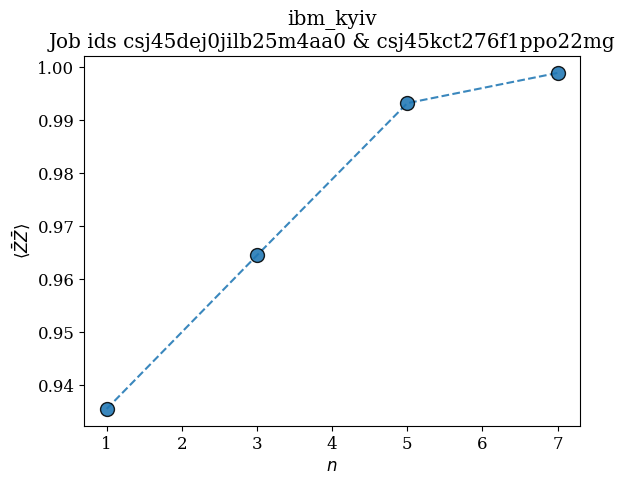

In [21]:
import numpy as np

xvals = [1] + nvals
yvals = [raw_value] + lst_values

save_key = f"{computer.name}_logical_bell_n357_depth_{depth}_{time_key}_job_id_{job.job_id()}_batch_job_id_{job_batch.job_id()}_dd"

plt.plot(xvals, yvals, "--o", ms=10, mec="black", alpha=0.88)

plt.xlabel("$n$")
plt.ylabel(r"$\langle \bar{Z} \bar{Z} \rangle$");
plt.title(f"{computer.name}\nJob ids {job.job_id()} & {job_batch.job_id()}")
plt.savefig(f"{save_key}.pdf")

In [22]:
for n, counts in zip(nvals, all_counts):
    print(n, counts.get("0" * n * k))

3 6905
5 3626
7 4002


In [23]:
opcounts = []
for nqubits, circuit in zip(xvals, [compiled_raw] + to_run):
    print(circuit.count_ops())
    oneq = 0
    twoq = 0
    for gate, count in list(circuit.count_ops().items()):
        if gate in ("rz", "sx", "x"):
            oneq += count
        if gate in ("ecr", "cz", "cx"):
            twoq += count
    print("Oneq:", oneq)
    print("Twoq:", twoq)
    print("Total:", oneq + twoq)
    opcounts.append([nqubits, oneq, twoq])

OrderedDict([('rz', 9), ('sx', 5), ('measure', 2), ('ecr', 1), ('barrier', 1)])
Oneq: 14
Twoq: 1
Total: 15
OrderedDict([('rz', 55), ('sx', 31), ('ecr', 14), ('measure', 6), ('x', 3), ('barrier', 1)])
Oneq: 89
Twoq: 14
Total: 103
OrderedDict([('rz', 147), ('sx', 83), ('ecr', 43), ('measure', 10), ('x', 5), ('barrier', 1)])
Oneq: 235
Twoq: 43
Total: 278
OrderedDict([('rz', 162), ('sx', 91), ('ecr', 49), ('measure', 14), ('x', 7), ('barrier', 1)])
Oneq: 260
Twoq: 49
Total: 309


## Save all data

In [24]:
# Save the opcounts.
np.savetxt(f"{save_key}_counts.txt", opcounts, header="nqubits, one-qubit gates, two-qubit gates")

In [25]:
# Save the nqubits, expectation values data.
data = np.array([xvals, yvals]).T

np.savetxt(f"{save_key}_expectation_values.txt", data)

In [26]:
# Save the qubits used.
qubits = [list(x) for x in layout.values()]

import pandas as pd

df = pd.DataFrame(qubits)
df.to_csv(f"{save_key}_qubits.txt", header=False)